In [1]:
import pandas as pd

df = pd.read_csv('user_activity.csv - user_activities.csv')

In [2]:
df.head()

,user_id,date,activity_type,duration_minutes
0,13,2023-04-14,journaling,41
1,16,2023-04-19,journaling,30
2,1,2023-04-20,meditation,17
3,4,2023-04-18,guided_exercise,13
4,4,2023-04-08,meditation,55


In [3]:
df['date'] = pd.to_datetime(df['date'])
df['week_number'] = df['date'].dt.strftime('%U')

In [4]:
# Calculates the total weekly duration of each activity type per user.
weekly_duration = df.groupby(['user_id', 'activity_type', 'week_number']).agg({'duration_minutes': 'sum'}).reset_index()
print(weekly_duration)

     user_id    activity_type week_number  duration_minutes
0          1  guided_exercise          14                53
1          1  guided_exercise          15               134
2          1  guided_exercise          16                85
3          1  guided_exercise          17                84
4          1       journaling          14               139
..       ...              ...         ...               ...
248       20       journaling          18                42
249       20       meditation          14                62
250       20       meditation          15               209
251       20       meditation          16               162
252       20       meditation          17               109

[253 rows x 4 columns]


In [5]:
# Identifies the day of the week with the highest total duration for each activity type.
df['day_of_week'] = df['date'].dt.dayofweek
# (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
grouped_df = df.groupby(['activity_type', 'day_of_week']).agg({'duration_minutes': 'sum'}).reset_index()

max_duration_per_activity = grouped_df.groupby('activity_type').apply(lambda x: x.loc[x['duration_minutes'].idxmax()])

print(max_duration_per_activity[['activity_type', 'day_of_week', 'duration_minutes']])

                   activity_type  day_of_week  duration_minutes
activity_type                                                  
guided_exercise  guided_exercise            2               967
journaling            journaling            6              1561
meditation            meditation            4              1068


In [6]:
# Statistical tests if there are activity differences in the days of the week per user.
# Perform Kruskal-Wallis test.
from scipy.stats import kruskal
test_results = pd.DataFrame(columns=['user_id', 'statistic', 'p_value'])

for user_id in range(1, 21):  
    user_data = df[df['user_id'] == user_id]
    
    durations_by_day = []
    for day in range(7):  
        durations_by_day.append(user_data[user_data['day_of_week'] == day]['duration_minutes'])
    kruskal_result = kruskal(*durations_by_day)

    test_results = pd.concat([test_results, pd.DataFrame({'user_id': [user_id],
                                                          'statistic': [kruskal_result.statistic],
                                                          'p_value': [kruskal_result.pvalue]})],
                             ignore_index=True)

# Display test results
print(test_results)

   user_id  statistic   p_value
0        1  10.134945  0.119083
1        2  10.590681  0.101881
2        3   5.734541  0.453574
3        4   3.516204  0.741813
4        5   8.029233  0.235969
5        6   8.560819  0.199825
6        7   5.963625  0.427277
7        8   3.960406  0.682035
8        9  13.482990  0.035976
9       10   7.849630  0.249328
10      11   4.022242  0.673666
11      12   7.341174  0.290444
12      13   3.095792  0.796731
13      14        NaN       NaN
14      15   5.679337  0.460052
15      16   6.158032  0.405722
16      17   3.240796  0.778074
17      18   6.600925  0.359334
18      19   8.302073  0.216797
19      20   5.204054  0.517921


/var/folders/0c/yhckkwd9767bsr3v10cwg9bc0000gn/T/ipykernel_51290/478063684.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results, pd.DataFrame({'user_id': [user_id],


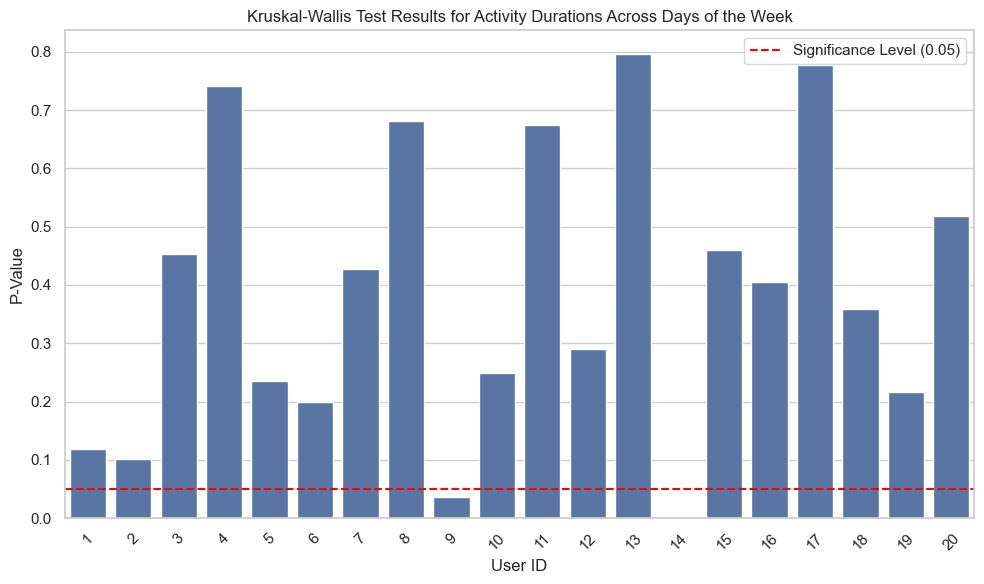

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Plot p-values for each user
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='user_id', y='p_value', data=test_results)
ax.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
ax.set_xlabel('User ID')
ax.set_ylabel('P-Value')
ax.set_title('Kruskal-Wallis Test Results for Activity Durations Across Days of the Week')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# For User 9:
user_9_data = df[df['user_id'] == 9]
grouped_df9 = user_9_data.groupby(['day_of_week','activity_type']).agg({'duration_minutes': 'sum'}).reset_index()

# Pivot table to separate activities by day of the week
pivot_table9 = user_9_data.pivot_table(index='activity_type', columns='day_of_week', values='duration_minutes', aggfunc='sum')

print(pivot_table9)

day_of_week         0      1     2     3     4     5     6
activity_type                                             
guided_exercise  16.0    NaN   NaN  44.0  27.0  23.0   5.0
journaling        NaN  151.0  65.0  52.0   NaN  96.0  18.0
meditation        NaN    NaN  84.0  73.0  57.0  80.0  92.0


In [9]:
# For User 9:
user_9_data = df[df['user_id'] == 9]
grouped_df9 = user_9_data.groupby(['day_of_week','activity_type']).agg({'duration_minutes': 'sum'}).reset_index()
grouped_df9

,day_of_week,activity_type,duration_minutes
0,0,guided_exercise,16
1,1,journaling,151
2,2,journaling,65
3,2,meditation,84
4,3,guided_exercise,44
5,3,journaling,52
6,3,meditation,73
7,4,guided_exercise,27
8,4,meditation,57
9,5,guided_exercise,23


In [10]:
# Identify which two days have the largest difference and whether it is statistically significant in activity.
import numpy as np
from scipy import stats
import itertools

day_pairs = list(itertools.combinations(range(7), 2))

activity_durations = {
    0: [16, 0, 0],
    1: [0, 151,0],
    2: [0, 65, 84],
    3: [44, 52, 73],
    4: [27, 0, 57],
    5: [23, 96, 80],
    6: [5, 18, 92]
}

# Perform pairwise t-tests
for pair in day_pairs:
    day1 = pair[0]
    day2 = pair[1]
    durations1 = activity_durations[day1]
    durations2 = activity_durations[day2]
    t_statistic, p_value = stats.ttest_ind(durations1, durations2)
    print(f"Pair: {pair}, T-Statistic: {t_statistic}, P-Value: {p_value}")

Pair: (0, 1), T-Statistic: -0.8890626561971902, P-Value: 0.42420521875735534
Pair: (0, 2), T-Statistic: -1.706109977567017, P-Value: 0.16318256579486132
Pair: (0, 3), T-Statistic: -5.019767169174617, P-Value: 0.007386568896876828
Pair: (0, 4), T-Statistic: -1.3098740185000133, P-Value: 0.2604003662638886
Pair: (0, 5), T-Statistic: -2.6770297602485815, P-Value: 0.05539936542078179
Pair: (0, 6), T-Statistic: -1.195028313825097, P-Value: 0.2980848308181056
Pair: (1, 2), T-Statistic: 0.011821701985375925, P-Value: 0.9911339816443165
Pair: (1, 3), T-Statistic: -0.11748406231926625, P-Value: 0.9121394096305216
Pair: (1, 4), T-Statistic: 0.42172575792449407, P-Value: 0.6949029573099352
Pair: (1, 5), T-Statistic: -0.290946496903723, P-Value: 0.7855547294809981
Pair: (1, 6), T-Statistic: 0.2099277040174474, P-Value: 0.8439832319751235
Pair: (2, 3), T-Statistic: -0.2481840421053994, P-Value: 0.8162125645969062
Pair: (2, 4), T-Statistic: 0.71519312822045, P-Value: 0.5140150264650246
Pair: (2, 5),

/var/folders/0c/yhckkwd9767bsr3v10cwg9bc0000gn/T/ipykernel_51264/4199423805.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(activity_durations.keys())


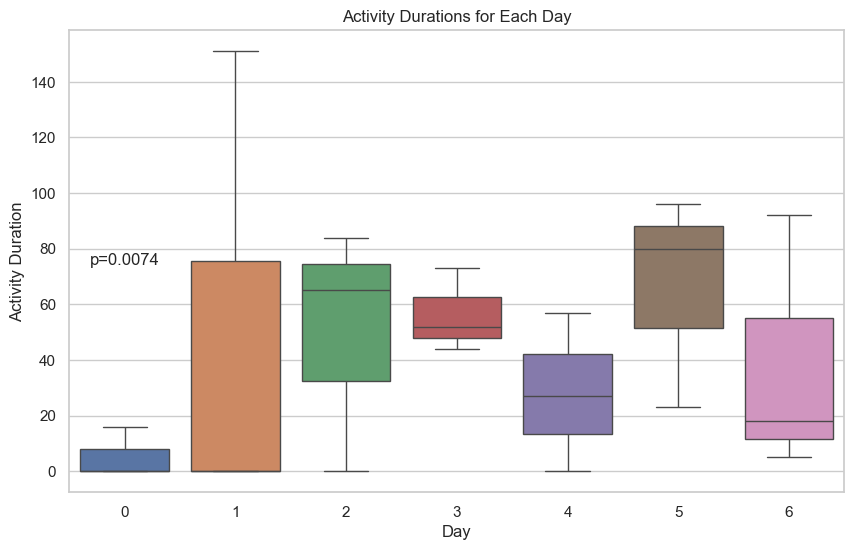

In [14]:
# Plot boxplot for activity durations for each day
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=list(activity_durations.values()))
ax.set_xticklabels(activity_durations.keys())
ax.set_xlabel("Day")
ax.set_ylabel("Activity Duration")
ax.set_title("Activity Durations for Each Day")

# Perform pairwise t-tests and annotate significant differences
for pair in day_pairs:
    day1 = pair[0]
    day2 = pair[1]
    durations1 = activity_durations[day1]
    durations2 = activity_durations[day2]
    t_statistic, p_value = stats.ttest_ind(durations1, durations2)
    if p_value < 0.05:  # Significance level of 0.05
        plt.text(pair[0], max(max(durations1), max(durations2)), f"p={p_value:.4f}", ha='center', va='bottom')

plt.show()